In [1]:
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('yarn').appName('tfidf').getOrCreate()

In [3]:
sc = spark.sparkContext

In [5]:
from pyspark.ml.feature import Tokenizer
setenceData = spark.createDataFrame([
    (0.0,'Hi I heard about Spark'),
    (0.0,'I wish Java could use case classes'),
    (1.0,'Logistic regression models are neat')
],['label','sentence'])

tokenizer = Tokenizer(inputCol='sentence',outputCol='words')
tokenizer.transform(setenceData).show()

+-----+--------------------+--------------------+
|label|            sentence|               words|
+-----+--------------------+--------------------+
|  0.0|Hi I heard about ...|[hi, i, heard, ab...|
|  0.0|I wish Java could...|[i, wish, java, c...|
|  1.0|Logistic regressi...|[logistic, regres...|
+-----+--------------------+--------------------+



In [7]:
df = spark.read.option('header','false').option('nullValue','?')\
                .option('inferSchema','true')\
                .csv('s3://ssds00/yes24-prep.csv')\
                .toDF('label','id','text')

df.show(5,truncate=False)

+---------------------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label                      |id           |text                                                                                                                                                                                                                                                                                                                 

In [10]:
from pyspark.ml.feature import HashingTF,Tokenizer
tokenizer = Tokenizer(inputCol='text',outputCol='words')
wordsData = tokenizer.transform(df)
wordsData.show(5)
hashingTF = HashingTF(inputCol='words',outputCol='tf',numFeatures=100000)
tfData = hashingTF.transform(wordsData)
tfData.show(5,truncate=False)

+---------------------------+-------------+--------------------------------+------------------------------+
|                      label|           id|                            text|                         words|
+---------------------------+-------------+--------------------------------+------------------------------+
|                   초한지 6|9788937481642| 단 한번 승리 천하 고조 유방 ...|  [단, 한번, 승리, 천하, 고...|
|                폭풍의 언덕|9791155510995|인간 애증 격정 치명 복수 화제...|  [인간, 애증, 격정, 치명, ...|
|            걸, 마돈나 세트|9788993480955|걸 직장 여성 심리 리얼 유쾌하...|  [걸, 직장, 여성, 심리, 리...|
|커피점 탈레랑의 사건 수첩 2|9791185217239| 잔 커피 년 추억 터키 속담 교...|  [잔, 커피, 년, 추억, 터키...|
|              무의미의 축제|9788937489327|농담 거짓말 의미 무의미 일상 ...|[농담, 거짓말, 의미, 무의미...|
+---------------------------+-------------+--------------------------------+------------------------------+
only showing top 5 rows

+---------------------------+-------------+-------------------------------------------------------------------------------------------

In [9]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol='tf',outputCol='tfidf')
idfModel = idf.fit(tfData)
tfidData = idfModel.transform(tfData)
tfidData.select('tf','tfidf').show(5)

+--------------------+--------------------+
|                  tf|               tfidf|
+--------------------+--------------------+
|(100000,[2102,352...|(100000,[2102,352...|
|(100000,[1427,331...|(100000,[1427,331...|
|(100000,[556,2681...|(100000,[556,2681...|
|(100000,[4,248,22...|(100000,[4,248,22...|
|(100000,[1299,226...|(100000,[1299,226...|
+--------------------+--------------------+
only showing top 5 rows



In [11]:
queryData = spark.createDataFrame([('개념 원리',),],['text',])
tokenizer = Tokenizer(inputCol='text',outputCol='words')
queryWords = tokenizer.transform(queryData)

queryFeaturized = hashingTF.transform(queryWords)
queryFeaturized.show(5,truncate=False)

+---------+------------+--------------------------------+
|text     |words       |tf                              |
+---------+------------+--------------------------------+
|개념 원리|[개념, 원리]|(100000,[33607,87643],[1.0,1.0])|
+---------+------------+--------------------------------+



In [13]:
queryTF = queryFeaturized.select('tf').collect()[0]['tf']
print(queryTF)
tfidData.rdd.map(lambda x:(x['label'],x['id'],x['tfidf'].dot(queryTF))).sortBy(lambda x : x[2],False).take(10)

(100000,[33607,87643],[1.0,1.0])


[('개념어 사전', 9788958624554, 65.36863384489347),
 ('개념-뿌리들', 9788976823816, 44.72590736755869),
 ('그래도 괜찮아', 9788953119499, 34.10522616021947),
 ('회사 개념어 사전', 9788965700456, 30.96408971600217),
 ('하나님의 학습법', 9788953113169, 30.315756586861752),
 ('헤르메스 가르침', 9791185010038, 30.315756586861752),
 ('예술이란 무엇인가', 9788958626091, 24.083180890223908),
 ('그림으로 이해하는 경제사상', 9788957691885, 24.083180890223908),
 ('돈보다 운을 벌어라', 9788965701361, 22.38780227967773),
 ('알기쉬운 역의 원리', 9788935702206, 22.038787119209136)]

In [14]:
def queryResult(title):
    queryData = spark.createDataFrame([(title,),],['text',])
    tokenizer = Tokenizer(inputCol='text',outputCol='words')
    queryWords = tokenizer.transform(queryData)

    queryFeaturized = hashingTF.transform(queryWords)
    queryFeaturized.show(5,truncate=False)
    queryTF = queryFeaturized.select('tf').collect()[0]['tf']
    print(queryTF)
    return tfidData.rdd.map(lambda x:(x['label'],x['id'],x['tfidf'].dot(queryTF))).sortBy(lambda x : x[2],False).take(10)

In [17]:
queryResult('김용대')

+------+--------+----------------------+
|text  |words   |tf                    |
+------+--------+----------------------+
|김용대|[김용대]|(100000,[70359],[1.0])|
+------+--------+----------------------+

(100000,[70359],[1.0])


[('초한지 6', 9788937481642, 0.0),
 ('폭풍의 언덕', 9791155510995, 0.0),
 ('걸, 마돈나 세트', 9788993480955, 0.0),
 ('커피점 탈레랑의 사건 수첩 2', 9791185217239, 0.0),
 ('무의미의 축제', 9788937489327, 0.0),
 ('포스트맨은 벨을 두 번 울린다', 9788937461699, 0.0),
 ('바보야, 성공이 아니라 섬김이야', 9788996786832, 0.0),
 ('절기서당', 9788997969289, 0.0),
 ('백로와 까마귀 1', 9788966473212, 0.0),
 ('새벽편지', 9788937405396, 0.0)]

In [18]:
documentDF = spark.read.option('inferSchema','true')\
                .option('header','false')\
                .csv('s3://ssds00/naver-movie-review-prep.csv')\
                .toDF('id','text','label')

print(documentDF.count())
documentDF.show(3,truncate=False)

138272
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|id     |text                                                                                                                                                                                                                                                                                                                                                                                  |label|
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
tokenizer = Tokenizer(inputCol='text',outputCol='words')
documentDF_tok = tokenizer.transform(documentDF)
documentDF_tok.show(10,truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=300,minCount=3,inputCol='words',outputCol='w2v')
model = word2Vec.fit(documentDF_tok)
model.getVectors().show(truncate=True)

+-----------+--------------------+
|       word|              vector|
+-----------+--------------------+
|  버거/noun|[0.01411182247102...|
|장희빈/noun|[-0.0116233080625...|
|실리콘/noun|[0.02275373041629...|
|  레빗/noun|[0.01449516136199...|
|  거장/noun|[-0.0390929095447...|
|  주장/noun|[0.09641305357217...|
|  색감/noun|[-0.0880655571818...|
|  꼬리/noun|[0.03838672116398...|
|  악용/noun|[0.01983422972261...|
|    꽃/noun|[0.11140253394842...|
|다빈치/noun|[0.01816168799996...|
|  앵/adverb|[-0.0476642400026...|
|전교조/noun|[0.01029493473470...|
|  인류/noun|[0.07677039504051...|
|거때매/noun|[-0.0203607715666...|
|멍멍/adverb|[-0.0274661183357...|
|  형성/noun|[0.07236309349536...|
|  극좌/noun|[0.00184618623461...|
|밸런스/noun|[0.00768224056810...|
|  코네/noun|[-0.0100595625117...|
+-----------+--------------------+
only showing top 20 rows



In [21]:
from pyspark.ml.feature import Word2VecModel
modelPath = 'word2vec-model'
model.save(modelPath)
loadedModel = Word2VecModel.load(modelPath)

modelPath = 'word2vec-model2'
model.write().overwrite().save(modelPath)
loadedeModel = Word2VecModel.load(modelPath)

In [22]:
print(model.findSynonymsArray('하다/verb',10))

[('해보다/verb', 0.5109309554100037), ('쫄딱/noun', 0.4706850051879883), ('일빠들/noun', 0.4665553867816925), ('오산/noun', 0.4565117359161377), ('해달라다/verb', 0.45022574067115784), ('기사도/noun', 0.4333327114582062), ('마카로니웨스턴/noun', 0.43158355355262756), ('금치/noun', 0.43093040585517883), ('시키다/verb', 0.4239439368247986), ('서슴없이/adverb', 0.4164365828037262)]


In [23]:
from pyspark.sql.functions import format_number as fmt
model.findSynonyms('영화/noun',10).select('word',fmt('similarity',5).alias('similarity')).show()

+---------------+----------+
|           word|similarity|
+---------------+----------+
|  액션영화/noun|   0.52418|
|    드라마/noun|   0.52346|
|다큐멘터리/noun|   0.51915|
|      애니/noun|   0.51630|
|  전쟁영화/noun|   0.49834|
|  만화영화/noun|   0.48856|
|  공포영화/noun|   0.47769|
|      정령/noun|   0.47740|
|  러시아워/noun|   0.46699|
|      명화/noun|   0.46250|
+---------------+----------+



In [24]:
samples = model.getVectors().rdd.takeSample(False,400,777)

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.font_manager._rebuild()
plt.rc('font',family='NanumGothic')
mpl.rcParams['axes.unicode_minus']=False

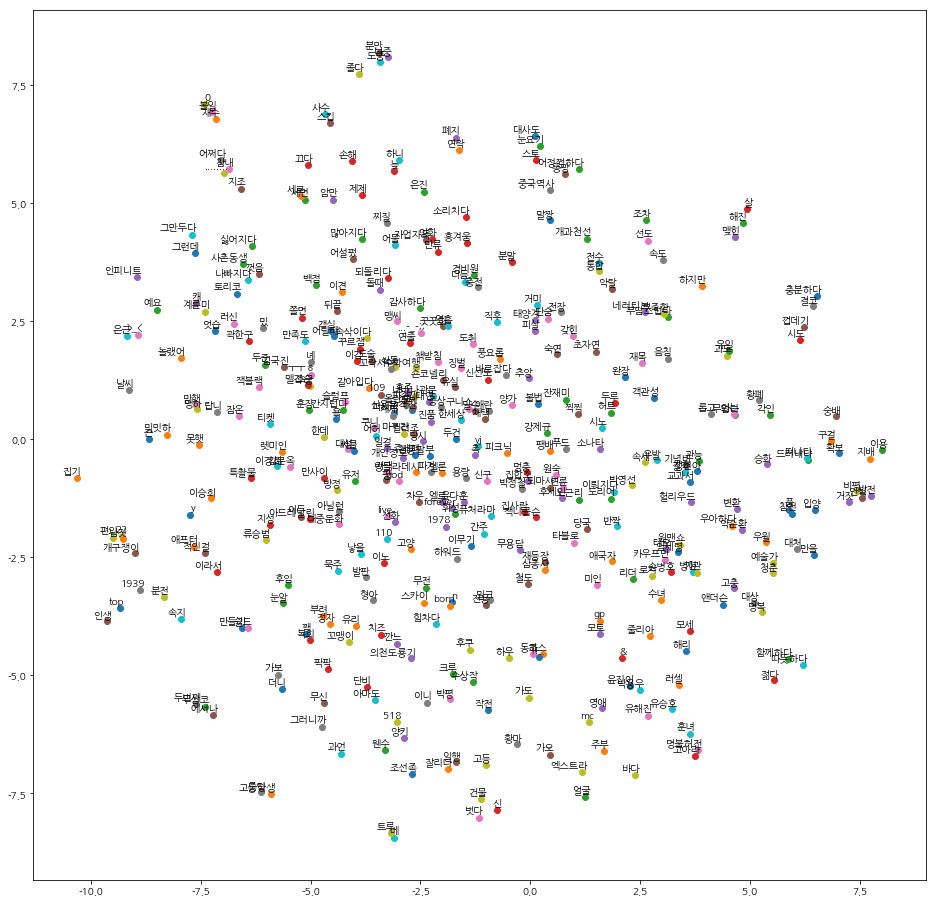

In [26]:
def plot_with_labels(low_dim_embs,labels,filename='tsne.png'):
    plt.figure(figsize=(16,16))
    for i, label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label.split('/')[0],xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
        

        

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity = 30,n_components=2,init='pca',n_iter=5000)
plot_only=400

low_dim_embs = tsne.fit_transform([list(i[1]) for i in samples])
labels = [i[0] for i in samples]
plot_with_labels(low_dim_embs,labels)

In [27]:
df == spark.read.option('header','false').option('nullValue','?')\
            .option('inferSchema','true').csv('s3://ssds00/yes24-prep.csv')\
            .toDF('label','id','text')

df.show()

+--------------------------------+-------------+----------------------------------+
|                           label|           id|                              text|
+--------------------------------+-------------+----------------------------------+
|                        초한지 6|9788937481642|   단 한번 승리 천하 고조 유방 ...|
|                     폭풍의 언덕|9791155510995|  인간 애증 격정 치명 복수 화제...|
|                 걸, 마돈나 세트|9788993480955|  걸 직장 여성 심리 리얼 유쾌하...|
|     커피점 탈레랑의 사건 수첩 2|9791185217239|   잔 커피 년 추억 터키 속담 교...|
|                   무의미의 축제|9788937489327|  농담 거짓말 의미 무의미 일상 ...|
|    포스트맨은 벨을 두 번 울린다|9788937461699|   포스트맨 벨 두 번 케인 데뷔 ...|
|  바보야, 성공이 아니라 섬김이야|9788996786832|  엘리 제 쉐핑 이야기 바보 성공...|
|                        절기서당|9788997969289|  세기 도시 복판 만약 지금 시간...|
|                 백로와 까마귀 1|9788966473212|  유쾌 상쾌 통쾌 아웅다웅 친구 ...|
|                        새벽편지|9788937405396|  정호승 편지 결 연한 절망 어조...|
|                 심리학 전공하기|9788975813801|  심리학 하위 분야 심리학 자기 ...|
|              아내를 사랑한 여자|9788

In [30]:
from pyspark.ml.feature import Tokenizer,CountVectorizer, StopWordsRemover
stopwords = ['짖', '큉', '텄', '데', '곤', '의미', '필', '닝', '야', '훤', '곽', '햄', '침', '늪', '팬', '탯', '맷', '끝', '절', '복', '십', '봬', '셤', '직', '툰', '촌', '사람', '혼', '넌', '냔', '돔', '생', '값', '렘', '푼', '순', '엿', '뽕', '헤', '뱃', '엮', '세', '맛', '헝', '롯', '겸', '간', '령', '히', '빚', '웰', '루', '뚱', '빅', '앰', '층', '뤽', '탁', '멱', '랩', '쇄', '투', '흥', '헨', '립', '홈', '탓', '횡', '겉', '눙', '쾌', '헛', '갓', '인', '겔', '꾼', '사랑', '숙', '락', '빵', '덫', '쭉', '댁', '젖', '퍽', '뜸', '뇌', '졔', '쇳', '하나', '꾐', '길', '폭', '덩', '자신', '족', '캔', '얘', '봐', '누', '지금', '주', '아', '놨', '둘', '적', '굴', '샹', '혹', '릴', '윌', '액', '엘', '흠', '획', '난', '귀', '헌', '셈', '납', '훨', '왈', '술', '철학', '슌', '삯', '추', '엡', '렀', '흑', '컵', '엽', '쥐', '갉', '셸', '뭐', '록', '긍', '숨', '디', '팍', '틈', '닭', '쟈', '고', '곰', '땋', '텐', '곧', '벽', '콰', '떄', '쎈', '페', '나', '판', '반', '짚', '밭', '레', '즈', '넉', '최', '썅', '괴', '음', '악', '캅', '딸', '분', '쏠', '샤', '펫', '느', '았', '빨', '종', '블', '틔', '퀵', '법', '볼', '강', '푹', '릐', '욥', '땡', '시간', '돛', '펜', '맴', '썸', '뵈', '단', '톰', '컨', '계', '뎁', '롤', '자', '쌍', '뒷', '몇', '땀', '솀', '앤', '땔', '틴', '및', '빗', '쾭', '낱', '톤', '뇽', '놀', '우리', '봉', '쯤', '것', '짓', '퇴', '굿', '외', '쳔', '뭣', '썻', '냉', '쳑', '뿜', '퉁', '조', '양', '방법', '점', '꽤', '팩', '찜', '때문', '죽', '칩', '뼈', '인간', '쿵', '윗', '기', '축', '광', '하나님', '돌', '밀', '킴', '얽', '닥', '걸', '개', '규', '방', '뚝', '벌', '훑', '뀌', '몽', '겹', '엎', '낭', '능', '껌', '암', '삭', '킥', '댓', '겁', '뭔', '탕', '바', '삼', '류', '엣', '사건', '즉', '펠', '김', '헉', '욕', '탑', '젤', '옹', '뼘', '딜', '옥', '빠', '짱', '칙', '티', '각', '곪', '숲', '날', '윙', '짬', '국', '햘', '념', '현', '가지', '멋', '씰', '빈', '징', '금', '넬', '떼', '믄', '쌀', '윽', '쫄', '콩', '노', '퐁', '득', '풀', '슐', '결', '총', '녹', '퓌', '쩌', '욱', '물', '킹', '쪼', '홱', '슥', '쎄', '검', '털', '봄', '웠', '궂', '웃', '잉', '숱', '깇', '육', '쾅', '뤠', '컬', '낮', '첫', '일', '왷', '캘', '합', '맵', '뻔', '번', '킨', '효', '귄', '뎅', '놈', '꽃', '뚜', '엄', '땜', '흐', '옴', '퀼', '왠', '수', '얼', '찬', '닉', '꿸', '잔', '뒤', '밍', '쟁', '룸', '망', '프', '당', '혈', '삽', '딥', '핏', '여', '맥', '섭', '무엇', '또', '독', '쿨', '온', '팝', '핫', '삵', '네', '림', '켜', '흉', '탈', '팟', '톈', '깡', '뻘', '별', '달', '갑', '델', '너', '작가', '묵', '뿔', '옷', '슛', '료', '대한', '툭', '덱', '윅', '닢', '욜', '밑', '린', '꽉', '앗', '새', '균', '을', '크', '캣', '롱', '숭', '질', '펙', '늦', '컴', '왕', '벼', '때', '픽', '몸', '잡', '기도', '면', '뾔', '측', '팸', '언', '후', '뉘', '벅', '쑥', '즌', '챈', '짤', '송', '묘', '율', '갈', '텍', '감', '군', '솥', '컷', '앨', '작', '쿤', '모', '킵', '갖', '녘', '월', '재', '썩', '괘', '윔', '룡', '더', '저', '밤', '졸', '소', '쉬', '워', '렌', '편', '뿐', '덧', '명', '퀴', '딘', '뭬', '세계', '스', '휑', '널', '앞', '쿄', '포', '즞', '깃', '닻', '캰', '뤼', '실', '겨', '눈', '압', '풋', '문', '려', '어', '팁', '럼', '견', '꼭', '낙', '띠', '셀', '마음', '뇨', '탭', '만', '시대', '넨', '뻬', '공', '랄', '렁', '믹', '웜', '샴', '휙', '뷰', '맘', '확', '쳀', '근', '붇', '닳', '오', '둥', '북', '딕', '녀', '둑', '톺', '꿈', '섬', '덤', '싱', '극', '렉', '눞', '룻', '쟨', '궤', '촐', '헬', '힘', '브', '콘', '땅', '믜', '니', '맹', '힝', '붓', '벳', '렬', '뿌', '늘', '역', '증', '찌', '퀸', '찡', '줌', '앱', '쿡', '낚', '키', '캬', '살', '웬', '밥', '좇', '붕', '다', '쌤', '뭉', '틀', '캇', '활', '씌', '뭘', '융', '짝', '밸', '햅', '씨', '목', '옅', '냥', '곡', '함', '톨', '뜰', '삐', '턴', '쫗', '넥', '닌', '례', '우', '큐', '켓', '응', '큘', '론', '엠', '행', '곳', '성', '똥', '틸', '찍', '칡', '웡', '객', '솝', '잎', '롬', '은', '콱', '텅', '떤', '세상', '며', '뻥', '피', '폰', '매', '핀', '쇤', '담', '뺨', '맏', '괄', '산', '벨', '메', '빙', '즐', '팔', '책', '칭', '팽', '렙', '콧', '곱', '뢰', '화', '릿', '릭', '변', '옮', '인생', '삶', '옭', '드', '설', '뱅', '갤', '즘', '랏', '홀', '문제', '넷', '통해', '열', '꾀', '갠', '경', '꼴', '쉰', '상', '끼', '샨', '뭡', '형', '펍', '통', '윤', '뮬', '요', '쁠', '사회', '꺽', '쫌', '솔', '란', '넒', '묏', '끗', '턱', '팀', '도', '불', '윈', '툴', '혜', '얌', '춤', '색', '문학', '쨍', '폐', '벡', '초', '햐', '렸', '창', '치', '멩', '트', '베', '꿰', '땐', '쌈', '랭', '쉔', '므', '뉴', '멍', '핑', '풍', '쿰', '의', '척', '부', '르', '띤', '벗', '런', '표', '신', '옛', '꽝', '궐', '옆', '코', '충', '속', '철', '패', '저자', '향', '휘', '시', '회', '꾹', '업', '뫼', '골', '곁', '넴', '쟤', '체', '궁', '예', '뮈', '펀', '훅', '솜', '특', '교', '소설', '렐', '또한', '억', '숏', '관', '솅', '흙', '캠', '렴', '혁', '논', '콤', '해', '덕', '보', '찰', '쫙', '님', '품', '슨', '넋', '토', '로', '차', '래', '터', '좀', '곯', '람', '위', '백', '환', '정', '머', '처', '석', '꼬', '굽', '타', '택', '취', '콜', '힐', '학', '웹', '숍', '씬', '톱', '싹', '착', '혀', '덜', '엔', '협', '멕', '선', '두', '닐', '곶', '찧', '사', '흔', '붐', '염', '빽', '울', '연', '영', '채', '죄', '팅', '른', '눅', '짐', '밧', '쥬', '촉', '젋', '몫', '급', '대해', '마', '다른', '뻐', '집', '못', '껏', '손', '뭇', '이자', '밖', '제', '뜻', '얄', '햇', '약', '갛', '봇', '긱', '청', '독자', '넛', '애', '끈', '성경', '퓰', '과정', '셋', '갱', '젝', '항', '칼', '에', '습', '카', '댐', '낯', '웨', '배', '톡', '셨', '랠', '떫', '왜', '펑', '돈', '챌', '낼', '잭', '비', '호', '말', '링', '쟝', '귤', '년', '장', '맨', '잣', '빛', '위해', '글', '팥', '륄', '과', '첩', '짊', '떡', '캡', '얀', '작품', '랴', '훈', '몬', '게', '깽', '샘', '켄', '량', '파', '텀', '밈', '를', '식', '츠', '콴', '격', '러', '민', '무', '테', '현실', '누구', '움', '깨', '롭', '쩍', '률', '닷', '냇', '련', '휜', '안', '낫', '이야기', '임', '전', '흄', '완', '룬', '폴', '범', '펏', '읊', '걔', '태', '거', '알', '웅', '젠', '승', '중', '케', '첵', '쏙', '슬', '쇼', '럭', '운', '벧', '와', '휠', '썬', '답', '병', '준', '캐', '꼽', '남', '홍', '유', '훌', '괜', '듭', '쁘', '구', '익', '쿠', '숀', '믈', '숑', '킬', '꿀', '그', '칸', '쩐', '쿳', '름', '원', '역사', '싯', '건', '리', '옵', '뭍', '씩', '즙', '랍', '뽀', '쉘', '콕', '줄', '룰', '옌', '잠', '텔', '슈', '접', '륜', '가장', '평', '한국', '용', '권', '뮤', '첼', '챙', '친', '볕', '뱀', '이', '진', '폼', '던', '등', '챠', '꿩', '심', '핵', '쪽', '황', '듀', '빼', '라', '동', '셰', '얍', '그녀', '경험', '존', '딛', '겐', '똑', '첸', '셧', '째', '모습', '낌', '막', '팻', '덴', '퍼', '룽', '천', '하', '쑈', '듯', '괌', '랜', '돗', '션', '모든', '툼', '쇠', '내', '버', '눌', '힉', '힌', '칠', '끌', '빔', '휫', '뇰', '램', '켈', '픈', '농', '읍', '튤', '좌', '박', '렛', '숄', '었', '발', '입', '꽁', '펄']
tokenizer = Tokenizer(inputCol='text',outputCol='words')
df_tokenized = tokenizer.transform(df)

remover = StopWordsRemover(inputCol = 'words',outputCol = 'words_rm',stopWords=stopwords)
df_removed = remover.transform(df_tokenized)
cv = CountVectorizer(inputCol='words_rm',outputCol='vectors')

In [31]:
bow_model = cv.fit(df_removed)
df_bow = bow_model.transform(df_removed)

df_bow.show(5,truncate=False)

+---------------------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
from pyspark.ml.clustering import LDA

lda = LDA(k=10,maxIter=100,featuresCol='vectors')
model = lda.fit(df_bow)
topics = model.describeTopics(8)
print('the topics described by their top-weighted terms : ')
topics.show(truncate=False)

the topics described by their top-weighted terms : 
+-----+-------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                      |termWeights                                                                                                                                                                            |
+-----+-------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[19, 31, 20, 34, 83, 159, 9, 96]                 |[0.008578619616721671, 0.00797186474837212, 0.007437032523120383, 0.006122673913054503, 0.005352078987020549, 0.0044716987531473705, 0.004347945442142985, 0.00424494

In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import ArrayType,StringType
from pyspark.sql.functions import udf

vocab = [e for e in bow_model.vocabulary]
def id2word(vector):
    global vocab
    words = [vocab[int(i)] for i in vector]
    return words

id2word_udf = udf(id2word,ArrayType(StringType()))

topics.select(['topic','termIndices']).withColumn('termWords',id2word_udf(topics['termIndices'])).show(truncate=False)
transformed = model.transform(df_bow)
transformed.show(truncate=False)



+-----+-------------------------------------------------+------------------------------------------------------------------+
|topic|termIndices                                      |termWords                                                         |
+-----+-------------------------------------------------+------------------------------------------------------------------+
|0    |[19, 31, 20, 34, 83, 159, 9, 96]                 |[남자, 여자, 아이, 가족, 결혼, 엄마, 당신, 아버지]                |
|1    |[5011, 6231, 5833, 2863, 6574, 5969, 7822, 13897]|[우파니샤드, 수경, 진언, 와인, 다라니, 독송, 관세음보살, 스노우볼]|
|2    |[4204, 4301, 2761, 5743, 6293, 2889, 8005, 5617] |[북극, 삼총사, 백수, 임꺽정, 아시, 안데르센, 허풍, 덴마크]        |
|3    |[2401, 3024, 3780, 3118, 3436, 1834, 5702, 3978] |[한나, 연암, 낭송, 논술, 이청준, 검사, 바칼로레아, 윤동주]        |
|4    |[3, 0, 11, 22, 15, 26, 1, 10]                    |[현대, 인물, 세기, 성공, 대표, 문화, 시인, 최고]                  |
|5    |[1942, 1530, 2166, 1392, 2432, 2374, 2469, 1032] |[타라, 야구, 뤼팽, 유령, 독도, 링컨, 라임, 해리]           

In [34]:
import numpy as np
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.sql.functions import udf

def argmax(vec):
    return int(np.argmax(vec))

argmax_udf = udf(argmax,IntegerType())

transformed.withColumn('topicLabel',argmax_udf(transformed['topicDistribution']))\
        .select(['text','topicDistribution','topicLabel'])\
        .show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
transformed.withColumn('topicLabel',argmax_udf(transformed['topicDistribution']))\
            .groupBy('topicLabel')\
            .count()\
            .orderBy('count',ascending=False)\
            .show(truncate=False)

+----------+-----+
|topicLabel|count|
+----------+-----+
|4         |14864|
|0         |3912 |
|8         |2877 |
|9         |126  |
|5         |89   |
|6         |51   |
|7         |44   |
|2         |23   |
|3         |22   |
|1         |19   |
+----------+-----+

